In [1]:
import sys
if sys.platform.startswith('linux'): # or win
    print("in linux")
    file_path = "/home/ncslaber/109-2/tree_experiment/npy_depth/p_1_45/"
#     sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
else:
    file_path = r"G:/我的雲端硬碟/0327_align_depth/"

in linux


In [2]:
'''math tool'''
import csv
import numpy as np
import time

'''plot tool'''
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib.ticker as ticker

'''image tool'''
import cv2
import statistics # as sta

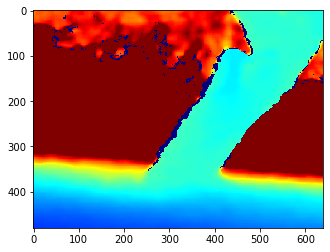

In [3]:
'''load file'''
npDepth = []
npDepth = np.load(file_path+"21.npy")

npDepthF = cv2.convertScaleAbs(npDepth, alpha=0.04) # 6m
npDepthF_color = cv2.applyColorMap(npDepthF, cv2.COLORMAP_JET)
plt.imshow(cv2.cvtColor(npDepthF_color, cv2.COLOR_BGR2RGB))

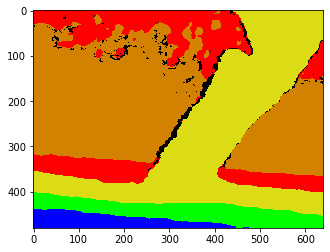

In [4]:
color_seq = {'brown': (0,130,210), 'red':(0,0,255),'yellow':(22,220,220),'green':(0,255,0),'blue':(255,0,0),'black':(0,0,0)}
npDepth_seg = np.zeros((npDepth.shape[0],npDepth.shape[1],3))

npDepth_seg[npDepth<1500]=color_seq['blue']
npDepth_seg[np.logical_and(npDepth<2000,npDepth>1500)]=color_seq['green']
npDepth_seg[np.logical_and(npDepth<3000,npDepth>2000)]=color_seq['yellow']
npDepth_seg[np.logical_and(npDepth<6000,npDepth>3000)]=color_seq['red']
npDepth_seg[npDepth>6000]=color_seq['brown']
npDepth_seg[npDepth==0]=color_seq['black']

%matplotlib inline
npDepth_seg = npDepth_seg.astype('uint8')
plt.imshow(cv2.cvtColor(npDepth_seg, cv2.COLOR_BGR2RGB))

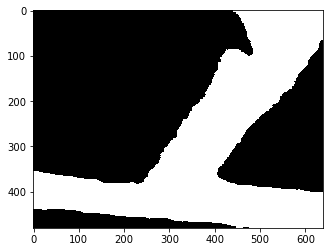

In [5]:
npDepth_binary = np.copy(npDepth)
npDepth_binary = npDepth_binary.astype('float32')

ret, npDepth_binary1 = cv2.threshold(npDepth_binary, 3000, 255, cv2.THRESH_BINARY_INV)
ret, npDepth_binary2 = cv2.threshold(npDepth_binary, 1500, 255, cv2.THRESH_BINARY)
npDepth_binary1 = npDepth_binary1.astype('uint8')
npDepth_binary2 = npDepth_binary2.astype('uint8')

npDepth_binary = cv2.bitwise_and(npDepth_binary1, npDepth_binary2)
npDepth_binary = npDepth_binary.astype('uint8')
plt.imshow(cv2.cvtColor(npDepth_binary, cv2.COLOR_BGR2RGB))

In [5]:
def depth(x,y):
    return npDepth[x][y]

class Point3D:
    x: int = 0
    y: int = 0
    z: int = 0

In [6]:
'''transform to 3D'''
cx_d = 328 #424
cy_d = 241 #241
fx_d = 617 #424
fy_d = 617 #424

npPointX = np.asarray(range(640))-cx_d
npPointX = np.diag(npPointX)
npPointX = npDepth.dot(npPointX)/ fx_d * (-1)

npPointY = np.asarray(range(480))-cy_d
npPointY = np.diag(npPointY)
theta = 0/180*np.pi
npPointY = npPointY.dot(npDepth)/ fy_d * (-1) 
npPointY = npPointY*np.cos(theta) + npDepth * np.sin(theta) + 360

npPointY = npPointY.astype('float16')

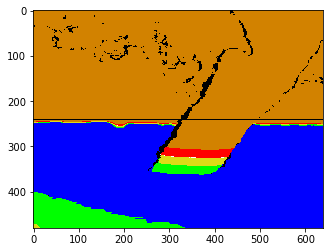

In [7]:
'''depth segmentation'''
npHeight = np.copy(npPointY)
color_seq = {'brown': (0,130,210), 'red':(0,0,255),'yellow':(22,220,220),
                'green':(0,255,0),'blue':(255,0,0),'black':(0,0,0)}
npHeight_seg = np.zeros((npDepth.shape[0],npDepth.shape[1],3))

npHeight_seg[npHeight<-160]=color_seq['blue']
npHeight_seg[np.logical_and(npHeight<-80,npHeight>-160)]=color_seq['green']
npHeight_seg[np.logical_and(npHeight<0,npHeight>-80)]=color_seq['yellow']
npHeight_seg[np.logical_and(npHeight<80,npHeight>0)]=color_seq['red']
npHeight_seg[npHeight>80]=color_seq['brown']
npHeight_seg[npHeight==360]=color_seq['black']
npHeight_seg[np.logical_and(npHeight<0.9,npHeight>-0.9)]=(255,255,255)
# print(*(npDepth[np.logical_and(npHeight<0.9,npHeight>-0.9)]))
%matplotlib inline
npHeight_seg = npHeight_seg.astype('uint8')
plt.imshow(cv2.cvtColor(npHeight_seg, cv2.COLOR_BGR2RGB))

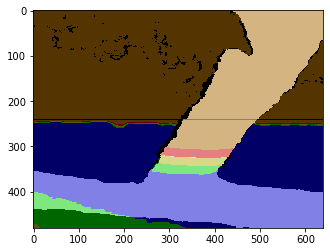

In [8]:
npDepth_copy = np.copy(npDepth_binary)
npDepth_copy = cv2.cvtColor(npDepth_copy,cv2.COLOR_GRAY2BGR)
npColorMask = cv2.addWeighted(npDepth_copy, 0.5, npHeight_seg, (0.4), 0.0)
plt.imshow(cv2.cvtColor(npColorMask, cv2.COLOR_BGR2RGB))

In [9]:
npHeight = np.copy(npPointY)
height,width = npHeight.shape
ground_height = np.array([])
layer = 20

ground_height = npHeight[height-layer*10: height][npHeight[height-layer*10: height]!=360]
ground_height = ground_height.astype('float64')

meanGrass = statistics.mean(ground_height)
medianGrass = statistics.median(ground_height)
stdevGrass = statistics.stdev(ground_height)

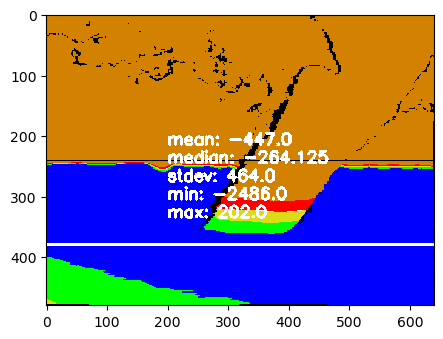

In [10]:
npHeight_seg_c = np.copy(npHeight_seg)
cv2.putText(npHeight_seg_c, #numpy array on which text is written
            'mean: '+str(np.trunc(meanGrass)), #text
            (200,200+15), #position at which writing has to start
            cv2.FONT_HERSHEY_SIMPLEX, #font family
            0.9, #font size
            (255,255,255), #font color
            3) #font stroke
cv2.putText(npHeight_seg_c, #numpy array on which text is written
            'median: '+str(medianGrass), #text
            (200,200+45), #position at which writing has to start
            cv2.FONT_HERSHEY_SIMPLEX, #font family
            0.9, #font size
            (255,255,255), #font color
            3) #font stroke
cv2.putText(npHeight_seg_c, #numpy array on which text is written
            'stdev: '+str(np.trunc(stdevGrass)), #text
            (200,200+75), #position at which writing has to start
            cv2.FONT_HERSHEY_SIMPLEX, #font family
            0.9, #font size
            (255,255,255), #font color
            3) #font stroke
cv2.putText(npHeight_seg_c, #numpy array on which text is written
            'min: '+str(np.min(ground_height)), #text
            (200,200+105), #position at which writing has to start
            cv2.FONT_HERSHEY_SIMPLEX, #font family
            0.9, #font size
            (255,255,255), #font color
            3) #font stroke
cv2.putText(npHeight_seg_c, #numpy array on which text is written
            'max: '+str(np.max(ground_height)), #text
            (200,200+135), #position at which writing has to start
            cv2.FONT_HERSHEY_SIMPLEX, #font family
            0.9, #font size
            (255,255,255), #font color
            3) #font stroke
cv2.line(npHeight_seg_c, (0,380),(640,380),(255,255,255),3)
%matplotlib inline
fig,ax = plt.subplots(figsize=(5,4), dpi = 100)
plt.imshow(cv2.cvtColor(npHeight_seg_c, cv2.COLOR_BGR2RGB))

(480, 640)


"\nmask = np.zeros_like(npHeight_copy)   \nlayer = 10\nregion_of_interyest_vertices = [(0, height-layer*10),(width, height-layer*10),(width,height),(0,height)] \ncv2.fillPoly(mask, np.array([region_of_interest_vertices], np.int32),255)\nmasked_img = cv2.bitwise_and(npHeight_copy, mask)\ncv2.imshow('threshold3', masked_img)\ncv2.waitKey(0)\n"

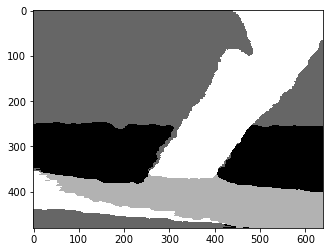

In [11]:
npHeight_binary = np.copy(npHeight)
npHeight_binary = npHeight_binary.astype('float32')

ret, npHeight_binary = cv2.threshold(npHeight_binary, -200, 255, cv2.THRESH_BINARY)
npHeight_binary = npHeight_binary.astype('uint8')

npBinarFuse = cv2.addWeighted(npDepth_binary, 0.7, npHeight_binary, (0.4), 0.0)
print(npBinarFuse.shape)
plt.imshow(cv2.cvtColor(npBinarFuse, cv2.COLOR_BGR2RGB))

'''
mask = np.zeros_like(npHeight_copy)   
layer = 10
region_of_interyest_vertices = [(0, height-layer*10),(width, height-layer*10),(width,height),(0,height)] 
cv2.fillPoly(mask, np.array([region_of_interest_vertices], np.int32),255)
masked_img = cv2.bitwise_and(npHeight_copy, mask)
cv2.imshow('threshold3', masked_img)
cv2.waitKey(0)
'''

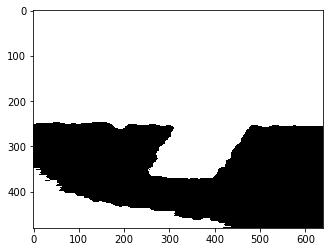

In [12]:
plt.imshow(cv2.cvtColor(npHeight_binary, cv2.COLOR_BGR2RGB))

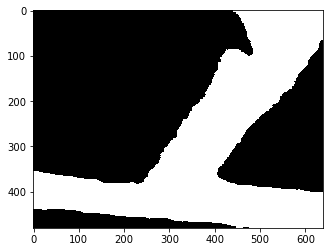

In [13]:
plt.imshow(cv2.cvtColor(npDepth_binary, cv2.COLOR_BGR2RGB))

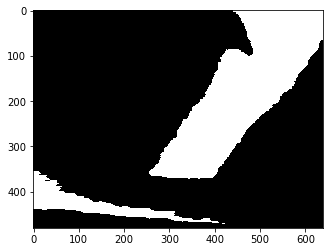

In [14]:
npTreeMask = cv2.bitwise_and(npDepth_binary, npHeight_binary)
plt.imshow(cv2.cvtColor(npTreeMask, cv2.COLOR_BGR2RGB))

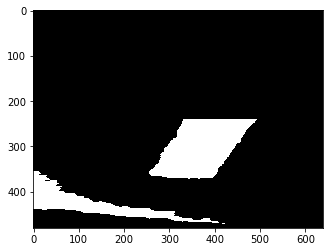

In [15]:
mask = np.zeros_like(npTreeMask)
region_of_interest_vertices = [(0,height/2),(0, height),(width, height),(width,height/2)]
cv2.fillPoly(mask, np.array([region_of_interest_vertices], np.int32), 255)
npTreeMask = cv2.bitwise_and(npTreeMask, mask)
plt.imshow(cv2.cvtColor(npTreeMask,cv2.COLOR_GRAY2RGB))

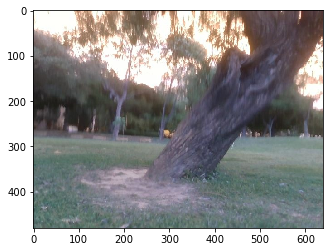

In [16]:
color = cv2.imread(file_path+'/color_img/21.0.jpg')
plt.imshow(cv2.cvtColor(color, cv2.COLOR_BGR2RGB))

uint8


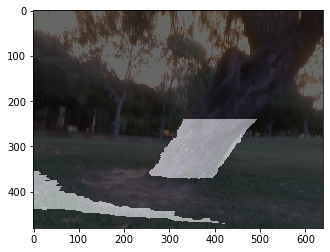

In [17]:
npTreeMask_c = cv2.cvtColor(npTreeMask, cv2.COLOR_GRAY2BGR)
npTreeMask_c = cv2.addWeighted(npTreeMask_c, 0.5, color, (0.4), 0.0)
plt.imshow(cv2.cvtColor(npTreeMask_c, cv2.COLOR_BGR2RGB))
print(npTreeMask.dtype)

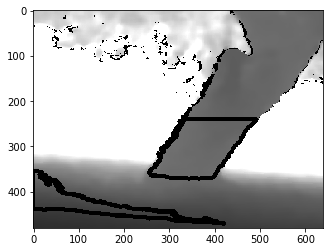

In [18]:
contours, hierarchy = cv2.findContours(npTreeMask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE) 
npDepthF_copy = np.copy(npDepthF)
npDepthF_copy = cv2.cvtColor(npDepthF_copy, cv2.COLOR_GRAY2BGR)
cv2.drawContours(npDepthF_copy, contours,-1,(0,0,0),8)  # contour is a list
plt.imshow(cv2.cvtColor(npDepthF_copy,cv2.COLOR_BGR2RGB))

In [20]:
'''Show all contours'''
for i in range(len(contours)):
    M = cv2.moments(contours[i])
    print(M["m00"], M["m10"], M["m01"])

0.0 0.0 0.0
0.0 0.0 0.0
10221.5 1217481.8333333333 4335944.166666666
12.0 4866.0 5616.0
4.0 962.0 1752.0
14.0 462.0 5362.0
16.0 520.0 6096.0
19.0 609.0 7183.333333333333
25.0 790.0 9382.333333333332
19150.5 7076510.666666666 5810010.5


here


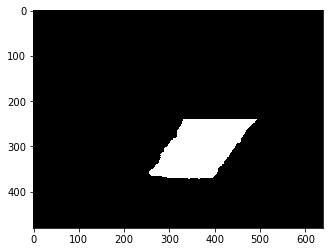

In [21]:
'''extract the only obj'''
allObj_plot = np.zeros(npDepth.shape, dtype='uint8')
moments = []
objSizeBound = 12000
index = []
i = 0
for ct in contours:
    obj_plot = np.zeros(npDepth.shape, dtype='uint8')
    cv2.fillPoly(obj_plot, [ct], 255)
#     cv2.imshow('obj',obj_plot)
#     cv2.waitKey(10)
    m = cv2.moments(ct)
    if m["m00"] > objSizeBound:
        cv2.fillPoly(allObj_plot, [ct], 255)
        moments.append(m)
        index.append(i)
    i = i+1
plt.imshow(cv2.cvtColor(allObj_plot,cv2.COLOR_BGR2RGB))

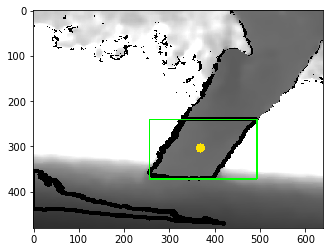

In [22]:
(x, y, w, h) = cv2.boundingRect(contours[index[0]])
cv2.rectangle(npDepthF_copy, (x, y), (x + w, y + h), (0, 255, 0), 2)
m = moments[0]
cX = int(m['m10'] / m['m00'])
cY = int(m['m01'] / m['m00'])
cv2.circle(npDepthF_copy, (cX, cY), 10, (1, 227, 254), -1)
plt.imshow(cv2.cvtColor(npDepthF_copy,cv2.COLOR_BGR2RGB))